In [96]:
#######################
#### Load packages ####
#######################


from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import warnings
import json
import sys
import numpy as np
# import csv
#import seaborn as sns
import pandas as pd
import time
#import arviz as az  # https://arviz-devs.github.io/arviz/index.html

#%tensorflow_version 2.x
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

 
import tensorflow_probability as tfp
#import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use('Agg')
tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops


Tensorflow version 2.2.0


In [82]:
###################
#### Functions ####
###################

def proper2geo_fn(xyz,distCenterLMC,alphaCenterLMC,deltaCenterLMC,
                      posAngleLMC,inclAngleLMC):
 
# Transform samples of location coordinates in the proper frame of the LMC
# to the rectangular heliocentric frame
#
# References:
#  Van der Marel & Cioni (2001)
#  Weinberg and Nikolaev (2001)
# 
# Parameters: 
# -xyz                 A tensor of shape=(N, 3) containing N samples in the
#                     proper LMC frame 
# -N                   No of samples
# -distCenterLMC       Distance to the LMC centre (kpc)
# -alphaCenterLMC      RA of the LMC centre (rad)
# -deltaCenterLMC      Dec of the LMC centre (rad)
# -posAngleLMC         Position angle of the LON measured w.r.t. the North (rad)
# -inclAngleLMC        Inclination angle (rad)
#
# Return:             A tensor of shape=(N, 3) containing N samples of rectangular 
#                    coordinates in the heliocentric frame                 
 


    # Affine transformation from local LMC frame to heliocentric frame 

    s11 = tf.sin(alphaCenterLMC)
    s12 = -tf.cos(alphaCenterLMC) * tf.sin(deltaCenterLMC)
    s13 = -tf.cos(alphaCenterLMC) * tf.cos(deltaCenterLMC)
    s21 = -tf.cos(alphaCenterLMC)
    s22 = -tf.sin(alphaCenterLMC) * tf.sin(deltaCenterLMC)
    s23 = -tf.sin(alphaCenterLMC) * tf.cos(deltaCenterLMC)
    s31 = tf.zeros([])
    s32 = tf.cos(deltaCenterLMC)
    s33 = -tf.sin(deltaCenterLMC)
 
    matrix = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ2 = tf.reshape(matrix, shape=output_shape)

    
    LMC_center = tf.stack(
        [
            distCenterLMC *
            tf.cos(deltaCenterLMC) *
            tf.cos(alphaCenterLMC),   
            distCenterLMC *
            tf.cos(deltaCenterLMC) *
            tf.sin(alphaCenterLMC),
            distCenterLMC *
            tf.sin(deltaCenterLMC)
        ], axis=0)


    S1_ = tf.linalg.LinearOperatorFullMatrix(OXYZ2)
    S1_ALO = tfb.AffineLinearOperator(shift=LMC_center, scale=S1_)

     
    # Linear transformation from proper to local LMC frame 
 
    
    s11 = tf.cos(posAngleLMC)  
    s12 = -tf.sin(posAngleLMC) * tf.cos(inclAngleLMC)  
    s13 = -tf.sin(posAngleLMC) * tf.sin(inclAngleLMC)
    s21 = tf.sin(posAngleLMC)  
    s22 = tf.cos(posAngleLMC) * tf.cos(inclAngleLMC)  
    s23 = tf.cos(posAngleLMC) * tf.sin(inclAngleLMC)  
    s31 = tf.zeros([])  
    s32 = -tf.sin(inclAngleLMC)  
    s33 = tf.cos(inclAngleLMC)  
     
 
    matrix2 = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ5 = tf.reshape(matrix2, shape=output_shape)
 

    S2_ = tf.linalg.LinearOperatorFullMatrix(OXYZ5)
    S2_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S2_)
    

    chain = tfb.Chain([  S1_ALO,  S2_ALO])

    return chain._forward( xyz, axis=1) 

 

def disk_fn(n, scaleHeight, scaleLength, psiAngle, ellFactor):
 
# Generate samples of location coordinates of the LMC disk in a proper  
# reference frame and transform them to a proper LMC reference frame 
# References:
#  Mancini et al. (2004)
#
# Parameters: 
# -N                   No of samples
# -scaleHeight         Disk scale height (kpc)
# -scaleLength         Disk scale length (kpc)
# -ellFactor           Disk ellipticity factor. For a circular disk set = 1                                                  
# -psiAngle            Disk minor axis position angle measured w.r.t. LON (rad)
#                     For a circular disk set = 0
#
# Return:             A tensor of shape=(n, 3) containing N samples of the   
#                    star locations in a local LMC reference frame                
 

    s11 =  tf.cos(psiAngle) 
    s12 = -tf.sin(psiAngle)   
    s13 = tf.zeros([])
    s21 =  tf.sin(psiAngle)
    s22 =  tf.cos(psiAngle)  
    s23 = tf.zeros([])
    s31 = tf.zeros([])  
    s32 = tf.zeros([])  
    s33 = tf.ones([])
 
    matrix = tf.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = tf.concat((
        tf.shape(input=tf.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ6 = tf.reshape(matrix, shape=output_shape)

    S3_ = tf.linalg.LinearOperatorFullMatrix(OXYZ6)
    S3_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S3_)
    
    r = tfd.Gamma(concentration=2, rate=1./scaleLength).sample(n )
    theta = tfd.Uniform(low=0., high=2.*np.pi).sample(n )

    x = ellFactor * r * tf.cos(theta)
    y = r * tf.sin(theta)

    z = tfd.Laplace(loc=0., scale=scaleHeight).sample(n )

    chain = tfb.Chain([  S3_ALO ])

    return chain._forward(tf.stack([x, y, z], axis=1))

def geo2plx_fn( x  ):
# Transform rectangular heliocentric coordinates to (ra,dec,parallax) coordinates

        x0 = x[..., 0]
        x1 = x[..., 1]
        x2 = x[..., 2]
        y0 = array_ops.where(
                gen_math_ops.greater(x1, 0.0),
                math_ops.scalar_mul(180.0/np.pi, math_ops.atan2(x1, x0)),
                math_ops.scalar_mul(180.0/np.pi, math_ops.atan2(x1, x0)) + 360.0)
        y2 = 1./math_ops.sqrt(
                math_ops.reduce_sum(math_ops.multiply(x, x), axis=1))

        # y2 = tf.linalg.norm(x, axis=1)
        y1 = math_ops.scalar_mul(180.0/np.pi, math_ops.asin(x2/(1./y2)))
        return array_ops.stack([y0, y1, y2], axis=1)

 

def measurements_fn(x , raErrorMean, raErrorVar , decErrorMean, 
                    decErrorVar, plxErrorMean, plxErrorVar ): 
    
    n =  x.numpy().shape[0]

    raErrorShape  = (raErrorMean ** 2)/raErrorVar
    raErrorScale  = raErrorVar/raErrorMean 

    decErrorShape  = (decErrorMean ** 2)/decErrorVar
    decErrorScale  = decErrorVar/decErrorMean 

    plxErrorShape  = (plxErrorMean ** 2)/plxErrorVar
    plxErrorScale  = plxErrorVar/plxErrorMean 

    ra_error = tfd.Gamma(concentration=raErrorShape, 
                         rate=1./raErrorScale).sample(n )
    
    dec_error = tfd.Gamma(concentration=decErrorShape, 
                          rate=1./decErrorScale).sample(n )
    
    plx_error = tfd.Gamma(concentration=plxErrorShape, 
                          rate=1./plxErrorScale).sample(n )

    x0 = x[..., 0]
    x1 = x[..., 1]
    x2 = x[..., 2]

    uncs = array_ops.stack([ra_error, dec_error, plx_error], axis=1)

    

    obs =  tfd.MultivariateNormalDiag(loc=x,
                                      scale_diag=uncs).sample(1) 

    return obs, uncs 

     

 



In [83]:
import astroabc

In [84]:
def simu_LMC(param,pool=None):
    # LMC fixed hyperparameters
    
    dist_centre_lmc=param[0]
    #print(dist_centre_lmc)
    alpha_centre_lmc=80.8939*np.pi/180. 
    delta_centre_lmc=-69.7561*np.pi/180.
    pos_angle_lmc=(122.5 + 90.)*np.pi/180.
    inc_angle_lmc=34.7*np.pi/180. 

    # Disk component fixed hyperparameters
    disk_scale_height = 0.35
    disk_scale_length = 1.6
    pos_angle_disk = 202.7*np.pi/180
    ell_factor_disk = 0.688 
    # Set No of samples we want to generate
    N = 1000000   
    if dist_centre_lmc>0:
    # Generate disk location coordinates in the LMC proper reference frame
        xyz_proper = disk_fn(N, disk_scale_height, disk_scale_length, 
                         pos_angle_disk - pos_angle_lmc, ell_factor_disk)

    # Transform from proper to heliocentric frame
        xyz_geo =  proper2geo_fn(xyz_proper, dist_centre_lmc, alpha_centre_lmc,
                             delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

        # Generate (ra,dec,plx) true values

        cyl_plx  =   geo2plx_fn(xyz_geo)

        result=np.array(cyl_plx)
        ra=result[:,0]
        dec=result[:,1]
        parallax=result[:,2]
        ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=10, range=None, expand_binnumbers=False)
        meanresult=ret.statistic
        sym=np.reshape(meanresult,100)
    else:
        sym=np.array([0])
    return sym
    
    
    
    

In [114]:
####################################
### Generate synthetic catalogue ###
####################################

# LMC fixed hyperparameters
dist_centre_lmc=50. 
alpha_centre_lmc=80.8939*np.pi/180. 
delta_centre_lmc=-69.7561*np.pi/180.
pos_angle_lmc=(122.5 + 90.)*np.pi/180.
inc_angle_lmc=34.7*np.pi/180. 

# Disk component fixed hyperparameters
disk_scale_height = 0.35
disk_scale_length = 1.6
pos_angle_disk = 202.7*np.pi/180
ell_factor_disk = 0.688 

# Uncertainty on measurements roughly estimated from the catalogue
ra_error_mean   = 0.1711426
ra_error_var = 0.006506719

dec_error_mean    =  0.1804739
dec_error_var = 0.007289793 

plx_error_mean  =  0.1758596
plx_error_var = 0.006775405 


# Set No of samples we want to generate
N = 1000000   

# Generate disk location coordinates in the LMC proper reference frame
xyz_proper = disk_fn(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geo =  proper2geo_fn(xyz_proper, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plx  =   geo2plx_fn(xyz_geo)

# Generate (ra,dec,plx) measurements & uncertainties

#measurements_fn(cyl_plx , ra_error_mean, ra_error_var , 
#                dec_error_mean, dec_error_var,  plx_error_mean, plx_error_var )  


In [115]:
simu=np.array(cyl_plx)

In [116]:
ra=simu[:,0]
dec=simu[:,1]
parallax=simu[:,2]

ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=10, range=None, expand_binnumbers=False)

mean=ret.statistic

xedges=ret.x_edge

yedges=ret.y_edge

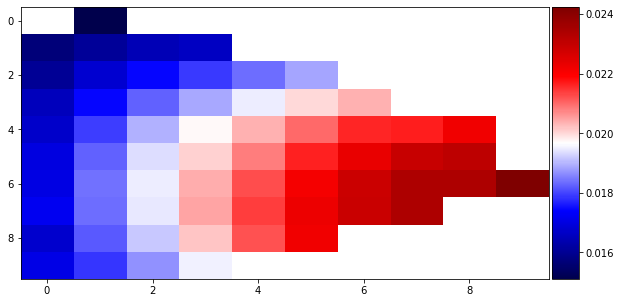

In [119]:
plt.figure(figsize=(10,5))
im=plt.imshow(mean, aspect='auto',interpolation="nearest", origin="upper",cmap='seismic')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [85]:
def metric_asymetries(observed,simulated): # Function to compute the distance metric using Chi^2
    
   
    if simulated.size==1:
        mychisum=np.inf
    else:
        nanos=np.count_nonzero(np.isnan(simulated)) # Count the number of bins with nans
        lens=len(simulated)                      


        if nanos>0.99*lens:  # if more than 50% of the bins have nans assign distance=infinity
            mychisum=float('Inf')
        else:
            mychi=np.nansum(((observed-simulated)/sigma)**2) # Sum of all Chi^2 for each bin                  
            Nbin=abs(lens-nanos)                                 # Compute the number of bins without nans
            mychisum=np.sum(mychi)/Nbin                     # Normalization over the number of bins
    #print(mychisum)                       
    return mychisum

In [86]:
sigmam=np.ones((10,10))
sigma=np.reshape(sigmam,100)*0.001

In [87]:
priors =  [('uniform', [5., 200.])] # Define the priors por the parameters to explore

In [88]:
#prop={ 'dfunc':metric_asymetries,'verbose':1, 'adapt_t': True, 'pert_kernel':2 ,"mpi":False, 'mp': True, 'num_proc':6}

In [89]:
if __name__ == "__main__":
    prop={'tol_type':"exp","verbose":1,'adapt_t':True,'threshold':75,
        'pert_kernel':2,'variance_method':0, 'dfunc':metric_asymetries, 'restart':"restart_abc.txt", 'outfile':"abc_mpi.txt",'mpi':False,'mp':False,'num_proc':4,
        'from_restart':False}

In [90]:
def main():
    param=[50]
    data=simu_LMC(param)
    sampler = astroabc.ABC_class(1,10,data,[1000,1],20,priors,**prop)
    model_sim=simu_LMC
    
    
    sampler.sample(model_sim)

In [91]:
main()

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=2 	 numt=20 	 tol=[1000.0000,1.0000] exp
	 Priors= [('uniform', [5.0, 200.0])]
	 Step: 0 	 tol: 1000.0 	 Params: [153.67304366031442]
	 Step: 1 	 tol: 150.97002874234812 	 Params: [128.6899614252261]
	 Step: 2 	 tol: 128.81492088198763 	 Params: [70.48608705471901]
	 Step: 3 	 tol: 45.48607736092322 	 Params: [63.70615413973573]
	 Step: 4 	 tol: 27.968738585133043 	 Params: [51.654897242718505]
	 Step: 5 	 tol: 1.8356502407369995 	 Params: [51.71334842260326]
	 Step: 6 	 tol: 1.0 	 Params: [51.39272365064855]
